In [42]:
#importing dependencies
import datetime
import numpy as np
import matplotlib.pyplot as plt
import pyaurorax
import cartopy

import os
import cv2
import re
import platform
from tqdm.contrib.concurrent import process_map as tqdm_process_map
from tqdm.auto import tqdm

aurorax = pyaurorax.PyAuroraX()
at = aurorax.tools

import sys
if ("google.colab" in sys.modules):
    aurorax.download_output_root_path = "/content/ucalgary_data"
    aurorax.read_tar_temp_path = "/content/ucalgary_data/tar_temp_working"

#class for themis dataset objects
class ThemisMapDataset:

    def __init__(self, startDate, endDate, site_uid_list):
        self.dataset_name = "THEMIS_ASI_RAW"
        self.start_dt = startDate
        self.end_dt = endDate
        self.site_uid_list = site_uid_list

    def __str__(self):
        return f"THEMIS ASI RAW dataset: {self.start_dt}, {self.end_dt} at sites {self.site_uid_list}"
    
    def gen_movie(self, movieName: str, uid_num=1):
        r = aurorax.data.ucalgary.download(self.dataset_name, self.start_dt, self.end_dt, site_uid=self.site_uid_list[uid_num-1])

        # read in the timeframe of data
        data = aurorax.data.ucalgary.read(r.dataset, r.filenames, n_parallel=5)
        # scale images
        images_scaled = at.scale_intensity(data.data, min=1000, max=15000)

        # processing frames
        def process_frame(i):
            fig, ax = at.display(images_scaled[:, :, i], cmap="gray", returnfig=True)
            ax.text(5, 240, "THEMIS ASI", color="white", size=14)
            ax.text(5, 225, self.site_uid_list[uid_num-1].upper(), color="white", size=14)
            ax.text(145, 8, data.timestamp[i].strftime("%Y-%m-%d %H:%M:%S UTC"), color="white", size=11)
            filename = "movie_frames/%s_atha_themis.png" % (data.timestamp[i].strftime("%Y%m%d_%H%M%S"))
            os.makedirs(os.path.dirname(filename), exist_ok=True)
            plt.savefig(filename, bbox_inches="tight")
            plt.close()
            return filename

        if (platform.system() == "Darwin"):
            # pre-process frames serially
            frame_filename_list = []
            for i in tqdm(range(0, images_scaled.shape[-1]), total=images_scaled.shape[-1],
                          desc="Generating frame files: ", unit="frames"):
                frame_filename_list.append(process_frame(i))
        else:
            frame_filename_list = tqdm_process_map(
                process_frame,
                range(0, images_scaled.shape[-1]),
                max_workers=5,
                chunksize=1,
                desc="Generating frame files: ",
                unit="frames",
            )
        # generate movie using above processed frames
        at.movie(frame_filename_list, movieName+".mp4", n_parallel=5)

    def download_mosaic_data(self, center_lat, center_lon):
        #downloading THEMIS data from all sites listed
        data_download_objs = {}
        for site_uid in self.site_uid_list:
            download_obj = aurorax.data.ucalgary.download(self.dataset_name, self.start_dt, self.end_dt, site_uid=site_uid)
            data_download_objs[site_uid] = download_obj

        # reading in the data site-by-site - separation needed for mosaic
        self.data_list = []
        for site_uid, download_obj in data_download_objs.items():
            self.data_list.append(aurorax.data.ucalgary.read(download_obj.dataset, download_obj.filenames))

        # getting list of all skymaps close to date for each site
        skymap_download_objs = {}
        for site_uid in self.site_uid_list:
            download_obj = aurorax.data.ucalgary.download(
                "THEMIS_ASI_SKYMAP_IDLSAV",
                self.start_dt.replace(year=self.start_dt.year - 2),
                self.start_dt,
                site_uid=site_uid,
            )
            skymap_download_objs[site_uid] = download_obj

        # read and store the last list index skymap for each site, as that is most recent to the date of interest
        self.skymaps = []
        for site_uid, download_obj in skymap_download_objs.items():
            skymap = aurorax.data.ucalgary.read(download_obj.dataset, download_obj.filenames[-1])
            self.skymaps.append(skymap.data[0])
        
        # preparing the skymap data
        self.prepped_skymap = at.mosaic.prep_skymaps(self.skymaps, 110, n_parallel=2)

        # preparing the image data
        self.prepped_images = at.mosaic.prep_images(self.data_list)

        # defining the intensity scales for each site
        self.scale = {} 
        for site_uid in self.site_uid_list:
            self.scale[site_uid] = [3500, 14000]
            
        # creating projection
        self.center_lat = center_lat
        self.center_lon = center_lon
        self.projection_obj = cartopy.crs.NearsidePerspective(central_longitude=self.center_lat, central_latitude=self.center_lon)
        
        # creating geographic gridlines
        self.lat_locs = np.arange(0, 90, 10)
        self.lon_locs = np.arange(-180, 0, 20)
        
    def get_satellite_loc_data(self, start, end):
        programs = ["elfin"]
        platforms = [self.satellite.lower()]
        instrument_types = ["footprint"]
    
        s = aurorax.search.ephemeris.search(start, end, programs=programs, platforms=platforms, instrument_types=instrument_types, verbose=True)
    
        # Organize data into a list of dicts
        ephemeris_data = [e.__dict__ for e in s.data]
    
        # Create lists of lats and lons for all timestamps
        lats = []
        lons = []
        for i in range(len(ephemeris_data)):
            lats.append(ephemeris_data[i]['location_geo'].lat)
            lons.append(ephemeris_data[i]['location_geo'].lon)
        return lats, lons
        
    def convert_images_to_video(input_folder, output_file, fps):
        # get the list of image files in the input folder
        image_files = sorted([f for f in os.listdir(input_folder) if f.endswith('.png')])
        
        # sort the list based on numerical order of image files
        image_files.sort(key=lambda test_string : list(
        map(int, re.findall(r'\d+', test_string)))[0])
    
        # read the first image to obtain its dimensions
        first_image = cv2.imread(os.path.join(input_folder, image_files[0]))
        height, width, _ = first_image.shape
    
        # create a VideoWriter object to save the video
        fourcc = cv2.VideoWriter_fourcc(*'mp4v')  # specify the codec for the output video file
        video = cv2.VideoWriter(output_file, fourcc, fps, (width, height))
    
        # iterate over each image and write it to the video
        for image_file in image_files:
            image_path = os.path.join(input_folder, image_file)
            frame = cv2.imread(image_path)
            video.write(frame)
    
        # release the video writer and close the video file
        video.release()
        cv2.destroyAllWindows()
    
    def mosaic_satellite_overplot(self, satellite, map_extent=[-140, -80, 40, 75], center_lat=-100.0, center_lon=55.0, mosaic_dir="mosaic_plots", title="THEMIS ASI"):
        self.download_mosaic_data(center_lat, center_lon)
        
        # creating mosaic
        frame_num = self.start_dt
        self.mosaic = at.mosaic.create(self.prepped_images, self.prepped_skymap, frame_num, self.projection_obj,
                                  image_intensity_scales=self.scale)

        # adding gridlines
        self.mosaic.add_geo_contours(constant_lats=self.lat_locs, constant_lons=self.lon_locs, linestyle='--', color='black')

        '''overplotting satellite location data on mosaic visual'''

        # 2 hours of data from ElFIN
        self.satellite=satellite
        start = self.start_dt.replace(hour=self.start_dt.hour - 1)
        end = self.start_dt.replace(hour=self.start_dt.hour + 1)
        lats, lons = self.get_satellite_loc_data(start, end)

        # adding the footprint of ELFIN over 30 minutes
        self.mosaic.add_geo_contours(lats=lats, lons=lons, linestyle='-', color='red', bring_to_front=True)

        # getting exact location of satellite at time of mosaic
        s_lats, s_lons = self.get_satellite_loc_data(self.start_dt, self.end_dt)

        # adding the location of ELFIN at the exact time of this mosaic
        self.mosaic.add_geo_contours(lats=s_lats, lons=s_lons, color='red', bring_to_front=True, marker="o")

        # obtaining mosaic plot to customize layout
        self.map_extent = map_extent
        dt = self.data_list[0].timestamp[0]
        fig, geo_axes = self.mosaic.plot(map_extent, title=f"{title} - %s" % (dt.strftime("%Y-%m-%d %H:%M:%S")),
                                    returnfig=True)

        # plot the mosaic and add text
        plt.figure(fig.number)
        geo_axes.text(lons[0] - 15, lats[0] - 1, self.satellite.upper(), color="red", transform=cartopy.crs.PlateCarree(),
                      fontsize=14)  # Add label for satellite
        
        sites=""
        for site_uid in self.site_uid_list:
            sites+=site_uid+"_"
        sites = "["+sites[:-1]+"]"
        filename= f"{mosaic_dir}/%s {sites}_themis_mosaic_{self.satellite}_overplot.png" % (dt.strftime("%Y-%m-%d %H:%M:%S"))
        os.makedirs(os.path.dirname(filename), exist_ok=True)
        plt.savefig(filename)
        
    #todo: add labels for asi/satellite locations (optional)
    def mosaic_satellite_movie(self, satellite, map_extent=[-140, -80, 40, 75], center_lat=-100.0, center_lon=55.0, mosaic_dir= "mosaic_plots", fps=5):
        time_range=(self.start_dt.strftime("%Y-%m-%dT%H:%M"), self.end_dt.strftime("%Y-%m-%dT%H:%M"))
        self.download_mosaic_data(center_lat, center_lon)
        
        # 2 hours of data from ElFIN
        self.satellite=satellite
        start = self.start_dt.replace(hour=self.start_dt.hour - 1)
        end = self.start_dt.replace(hour=self.start_dt.hour + 1)
        lats, lons = self.get_satellite_loc_data(start, end)
        
        # Define all image indexes (0-99)
        frame_idx_arr = np.arange(len(self.prepped_images.timestamps))

        create_args = [[self.prepped_images, self.prepped_skymap, frame_idx, self.projection_obj, self.scale] for frame_idx in frame_idx_arr]

        def process_mosaic_frame(args):
            m = at.mosaic.create(args[0], args[1], args[2], args[3], image_intensity_scales=args[4])
            return m
        for i in range(len(self.prepped_images.timestamps)):
            # creating mosaic
            mosaic = process_mosaic_frame(create_args[i])
            
            # adding gridlines
            mosaic.add_geo_contours(constant_lats=self.lat_locs, constant_lons=self.lon_locs, linestyle='--', color='black')
            
            # adding ELFIN footprint over 30 minutes
            mosaic.add_geo_contours(lats=lats, lons=lons, linestyle='-', color='red', bring_to_front=True)
            
            # getting exact location of satellite at time of mosaic
            s_lats, s_lons = self.get_satellite_loc_data(self.start_dt, self.data_list[0].timestamp[i])
            
            # adding exact location of ELFIN at time of mosaic frame
            mosaic.add_geo_contours(lats=s_lats, lons=s_lons, color='red', bring_to_front=True, marker="o")
            
            # obtaining mosaic plot to customize layout
            dt = self.data_list[0].timestamp[i]
            fig, geo_axes = mosaic.plot(map_extent, title="THEMIS ASI - %s" % (dt.strftime("%Y-%m-%d %H:%M:%S")), returnfig=True)
            
            # plotting the mosaic and adding text
            plt.figure(fig.number)
            geo_axes.text(lons[0]-15,lats[0]-1,self.satellite.upper(), color="red", transform=cartopy.crs.PlateCarree(), fontsize=14) 
            frame_path = f'{os.getcwd()}/{mosaic_dir}/animations/images/%s_mosaic/mosaic_frame{i}.png' % self.start_dt.strftime("%Y%m%d_%H%M%S")
            plt.savefig(frame_path, bbox_inches='tight')
        
        path = f'{os.getcwd()}/{mosaic_dir}/animations/images/%s_mosaic' % self.start_dt.strftime("%Y%m%d_%H%M%S")
        out_path = f'{os.getcwd()}/{mosaic_dir}/'
        out_video_name = '%s_th_el_mosaic_movie.mp4' % (self.start_dt.strftime("%Y%m%d_%H%M%S")+self.end_dt.strftime("_%H%M%S"))
        out_video_full_path = out_path+out_video_name
        
        # call the function to convert the images to video
        self.convert_images_to_video(path, out_video_full_path, fps)
        
    def bounded_magnetic_lat_satellite_trace(self, satellite, start=None, end=None, site_uid=None, altitude_km=110, plot_dir="themis_plots"):
        self.hour_data_for_plots()
        ''' geomagnetic lat/lon bounding box graph tracing satellite trajectory'''
        self.plot_dir = plot_dir
        self.alt = altitude_km
        self.site_uid = self.site_uid_list[0].lower() if site_uid is None else site_uid.lower()
        
        # downloading THEMIS data
        start_dt = self.start_dt if start is None else start
        end_dt = self.end_dt if end is None else end
        r = aurorax.data.ucalgary.download(self.dataset_name, start_dt, end_dt, site_uid=self.site_uid)
        data = aurorax.data.ucalgary.read(r.dataset, r.filenames, n_parallel=5)
        themis_img = data.data
        themis_ts = data.timestamp
        
        # downloading corresponding THEMIS skymap
        start = datetime.datetime(self.start_dt.year-1, 1, 1)
        end = datetime.datetime(self.start_dt.year+1, 1, 1)
        r = aurorax.data.ucalgary.download("THEMIS_ASI_SKYMAP_IDLSAV", start, end, site_uid=self.site_uid, overwrite=True)
        themis_skymap = aurorax.data.ucalgary.read(r.dataset, r.filenames[-1]).data[0]
        
       # obtaining data from ELFIN satellite trajectory for bounding box
        self.satellite = satellite
        lats, lons = self.get_satellite_loc_data(start_dt, end_dt)
        
        # creating 20x20 km bounding box
        lon_lat=[]
        for i in range(len(lats)):
            lon_lat.append([lons[i]-10, lons[i]+10, lats[i]+10, lats[i]-10])
        
        luminosity = at.bounding_box.extract_metric.mag(themis_img, themis_ts[0], themis_skymap, altitude_km, lon_lat[0])
        
        # collecting data based on positions of ELFIN with luminosity metric
        diff = int(len(luminosity)/len(lon_lat))
        plot_arr=[]
        for i in range(diff,len(luminosity)+1,diff):
            count=1
            plot_arr.append(luminosity[i-diff:i])
            luminosity=at.bounding_box.extract_metric.mag(themis_img, themis_ts[0], themis_skymap, altitude_km, lon_lat[count])
            count+=1
        
        #plotting graph
        plt.figure()
        plt.plot(luminosity)
        plt.title(f"THEMIS within {self.satellite.upper()} Magnetic Lat\n%s" % start_dt.strftime("%Y-%m-%d"))
        plt.xlabel("Time (UTC)")
        plt.ylabel("Auroral Luminosity\nMedian Counts")
        plt.xticks(ticks=[i for i in range(0,len(themis_ts),10)], labels=[datetime.datetime.strftime(themis_ts[i],format="%H:%M") for i in range(0,len(themis_ts),10)])
        plt.savefig(f'{os.getcwd()}/{plot_dir}/THEMIS within {self.satellite.upper()} Magnetic Lat %s.png' % start_dt.strftime("%Y%m%d_%H%M%S"))
        

THEMIS ASI RAW dataset: 2022-03-05 12:25:00, 2022-03-05 12:30:00 at sites ['atha', 'fsmi', 'fsim']
20220305_122500_123000_mosaic.mp4: |################################### | 98%
frame  1  of  100
frame  2  of  100
frame  3  of  100
frame  4  of  100
frame  5  of  100
frame  6  of  100
frame  7  of  100
frame  8  of  100
frame  9  of  100
frame  10  of  100
frame  11  of  100
frame  12  of  100
frame  13  of  100
frame  14  of  100
frame  15  of  100
frame  16  of  100
frame  17  of  100
frame  18  of  100
frame  19  of  100
frame  20  of  100
frame  21  of  100
frame  22  of  100
frame  23  of  100
frame  24  of  100
frame  25  of  100
frame  26  of  100
frame  27  of  100
frame  28  of  100
frame  29  of  100
frame  30  of  100
frame  31  of  100
frame  32  of  100
frame  33  of  100
frame  34  of  100
frame  35  of  100
frame  36  of  100
frame  37  of  100
frame  38  of  100
frame  39  of  100
frame  40  of  100
frame  41  of  100
frame  42  of  100
frame  43  of  100
frame  44  of  

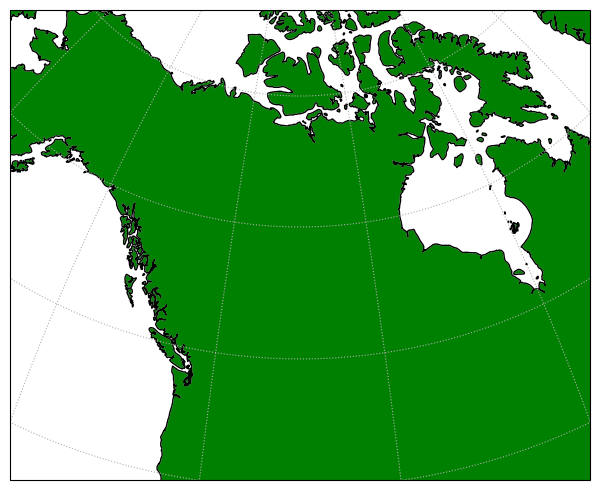

In [43]:

# testing object examples

plot1 = ThemisMapDataset(
    datetime.datetime(2022, 3, 5, 12, 25),
    datetime.datetime(2022, 3, 5, 12, 30),
    ['atha', 'fsmi', 'fsim']
)

print(plot1)

#plot1.mosaic_satellite_overplot('elfinb')

#plot1.gen_movie("plot4")

plot1.mosaic_satellite_movie()
